#Tema: Previsão do número de infecções por COVID-19 no Brasil utilizando a taxa reprodutiva estimada do vírus.
Autor: Rafael Bandoni  
Dados utilizados: Dados de COVID extraídos do [portal do governo](https://covid.saude.gov.br/).

##Resumo
Utilizando os algoritmos preditivos ARIMA e Prophet, tentei buscar o número possível de infectados por COVID-19 no Brasil nos próximos 30 dias. Para fazer isso, utilizei uma metodologia diferente, ao invés de tentar prever o número de casos, trabalhei com a taxa reprodutiva estimada do vírus (Re).
Esse valor mostra o número de pessoas que pode ser contaminada, em méda, por outra pessoa - Re = 2 signiica que um contaminado infecta até duas pessoas. Sendo assim, Re > 1 significa infecção em crescimento e Re < 1 significa infecção em declínio. Para o cálculo dessa variável foi usado o modelo ```epyestim```, uma reimplementação em python do pacote em R chamado ```EpiEstim``` [1].
Esse método é baseado no artigo de Huisman et al. [2], e utiliza inferência estatística como destacado por Cori et al. [3].

##Resultados:
Para escopo do trabalho, foram escolhidos os estados de Rio de Janeiro, São Paulo e Minas Gerais. Inicialmente, o estado do Espírito Santo também estava considerado, mas não foi possível calcular o Re por conta de uma incongruência na base de dados.  

Os resultados observados foram:  

Como observado nas previsões, o método ARIMA mostrou:
- Um pico de 1,25 nos próximos 40 dias em Minas Gerais;
- Um pico entre 1,35 e 1,2 nos próximos 40 dias em São Paulo;
- Um pico entre 1,35 e 1,2 nos próximos 40 dias no Rio de Janeiro.

Para as previsões Prophet tivemos:
- Pico de 1,3 em Minas Gerais;
- Pico de 1,5 em São Paulo;
- Pico de 1,4 no Rio de Janeiro.

E, com isso, podemos ter os seguintes outputs:
- Minas Gerais, da última vez que alcançou um Re entre 1,25 e 1,3, passou por 3 meses onde foram confirmados de 2.000 a 3.000 casos por dia em média móvel de 7 dias.
- São Paulo, da última vez que alcançou picos de 1,5 em Re, confirmava mais de 10.000 casos por dia durante um mês. E com o Re de 1,3 alcançava entre 6.000 e 8.000 confirmados por dia durante 2 meses.
- E o Rio de Janeiro, da última vez que alcançou picos entre 1,2 e 1,4 confirmava entre 2.000 e 2.500 por dia durante 2 meses.

###Referências

[1] EpiEstim CRAN package: https://cran.r-project.org/web/packages/EpiEstim/index.html

[2] Jana S. Huisman, Jeremie Scire, Daniel Angst, Richard Neher, Sebastian Bonhoeffer, Tanja Stadler: A method to monitor the effective reproductive number of SARS-CoV-2 https://ibz-shiny.ethz.ch/covid-19-re/methods.pdf

[3] Anne Cori, Neil M. Ferguson, Christophe Fraser, Simon Cauchemez: A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, American Journal of Epidemiology, Volume 178, Issue 9, 1 November 2013, Pages 1505–1512, https://doi.org/10.1093/aje/kwt133

#Importando e limpando bases e bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install epyestim

import epyestim
import epyestim.covid19 as covid19

from fbprophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

!pip install pmdarima
from pmdarima.arima import auto_arima

In [ ]:
caminho_covid = '/content/drive/MyDrive/Colab Notebooks/Bootcamp Data Science - Alura 2020/Módulo 4 - DataSUS/Desafio Final/HIST_PAINEL_COVIDBR_17jan2021.csv'

In [ ]:
dados_covid = pd.read_csv(caminho_covid, sep=';')
dados_covid['data'] = pd.to_datetime(dados_covid['data'])
dados_covid.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,NaN,NaN,NaN


##Separando a base de COVID entre BR, Estadual e Municipal

**Dados COVID**  
```
dados_covid_brasil  
dados_covid_estados  
dados_covid_cidades 
```

In [ ]:
#Há um problema nos dados, as semanas epidemiológicas vão até 53 e depois voltam para 1, 2 e 3, vou arrumar

dados_covid['semanaEpi'].loc[dados_covid['semanaEpi'] == 1] = 54
dados_covid['semanaEpi'].loc[dados_covid['semanaEpi'] == 2] = 55
dados_covid['semanaEpi'].loc[dados_covid['semanaEpi'] == 3] = 56

dados_covid.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
1669708,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2021-01-13,55,3015268.0,261456,659,4388,13,NaN,NaN,1.0
1669709,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2021-01-14,55,3015268.0,262222,766,4399,11,NaN,NaN,1.0
1669710,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2021-01-15,55,3015268.0,262928,706,4406,7,NaN,NaN,1.0
1669711,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2021-01-16,55,3015268.0,263756,828,4412,6,NaN,NaN,1.0
1669712,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2021-01-17,56,3015268.0,264227,471,4421,9,NaN,NaN,1.0


In [ ]:
dados_covid_cidades = dados_covid.query('regiao != "Brasil"')
dados_covid_cidades = dados_covid_cidades[dados_covid_cidades['municipio'].notna()]
dados_covid_cidades.reset_index(drop=True, inplace=True)
dados_covid_cidades.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-27,13,22945.0,0,0,0,0,NaN,NaN,0.0
1,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-28,13,22945.0,0,0,0,0,NaN,NaN,0.0
2,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-29,14,22945.0,0,0,0,0,NaN,NaN,0.0
3,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-30,14,22945.0,0,0,0,0,NaN,NaN,0.0
4,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-31,14,22945.0,0,0,0,0,NaN,NaN,0.0


In [ ]:
dados_covid_estados = dados_covid.query('regiao != "Brasil"')
dados_covid_estados = dados_covid_estados[dados_covid_estados['municipio'].isna()]
dados_covid_estados.reset_index(drop=True, inplace=True)
dados_covid_estados

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Norte,RO,NaN,11,NaN,NaN,NaN,2020-02-25,9,1777225.0,0,0,0,0,NaN,NaN,NaN
1,Norte,RO,NaN,11,NaN,NaN,NaN,2020-02-26,9,1777225.0,0,0,0,0,NaN,NaN,NaN
2,Norte,RO,NaN,11,NaN,NaN,NaN,2020-02-27,9,1777225.0,0,0,0,0,NaN,NaN,NaN
3,Norte,RO,NaN,11,NaN,NaN,NaN,2020-02-28,9,1777225.0,0,0,0,0,NaN,NaN,NaN
4,Norte,RO,NaN,11,NaN,NaN,NaN,2020-02-29,9,1777225.0,0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15088,Centro-Oeste,GO,NaN,52,520000.0,NaN,NaN,2021-01-13,55,NaN,0,0,0,0,NaN,NaN,NaN
15089,Centro-Oeste,GO,NaN,52,520000.0,NaN,NaN,2021-01-14,55,NaN,0,0,0,0,NaN,NaN,NaN
15090,Centro-Oeste,GO,NaN,52,520000.0,NaN,NaN,2021-01-15,55,NaN,0,0,0,0,NaN,NaN,NaN
15091,Centro-Oeste,GO,NaN,52,520000.0,NaN,NaN,2021-01-16,55,NaN,0,0,0,0,NaN,NaN,NaN


In [ ]:
dados_covid_brasil = dados_covid.query('regiao == "Brasil"')
dados_covid_brasil.reset_index(drop=True, inplace=True)
dados_covid_brasil.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,NaN,NaN,NaN


###Explorando a base Brasil

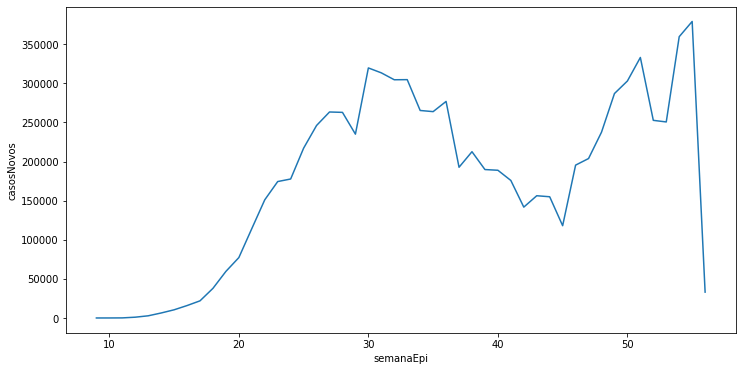

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=dados_covid_brasil.groupby('semanaEpi').sum(), x='semanaEpi', y='casosNovos')
plt.show();

###Agrupando por semana epidemiologica

In [ ]:
dados_covid_brasil_semana = dados_covid_brasil.groupby('semanaEpi').sum()
dados_covid_brasil_semana['est_r'] = dados_covid_brasil_semana['casosNovos'].divide(dados_covid_brasil_semana['casosNovos'].shift(1))
dados_covid_brasil_semana

,coduf,codmun,codRegiaoSaude,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana,est_r
semanaEpi,,,,,,,,,,,,
9,380,0.0,0.0,1.050736e+09,5,2,0,0,0.0,0.0,0.0,NaN
10,532,0.0,0.0,1.471030e+09,48,17,0,0,0.0,0.0,0.0,8.500000
11,532,0.0,0.0,1.471030e+09,432,102,0,0,0.0,0.0,0.0,6.000000
12,532,0.0,0.0,1.471030e+09,3806,1007,40,18,0.0,0.0,0.0,9.872549
13,532,0.0,0.0,1.471030e+09,18306,2775,445,96,0.0,0.0,0.0,2.755710
14,532,0.0,0.0,1.471030e+09,48630,6375,1827,318,0.0,0.0,0.0,2.297297
15,532,0.0,0.0,1.471030e+09,111052,10449,5627,692,0.0,0.0,0.0,1.639059
16,532,0.0,0.0,1.471030e+09,199887,15872,12231,1223,0.0,0.0,0.0,1.518997
17,532,0.0,0.0,1.471030e+09,329067,21910,21683,1669,178152.0,129232.0,0.0,1.380418


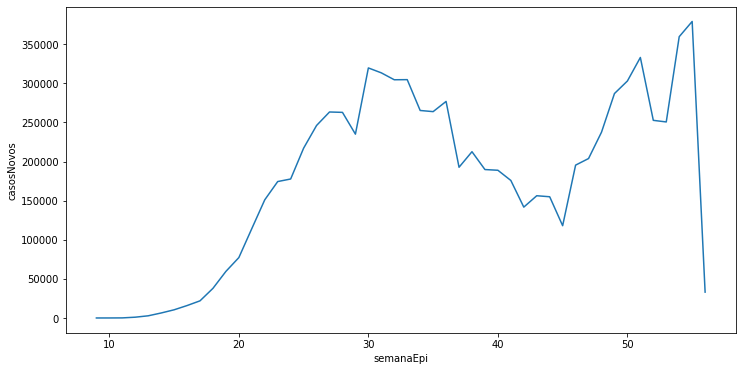

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=dados_covid_brasil_semana, x='semanaEpi', y='casosNovos')
plt.show();

#Explorando os Estados do sudeste
Focarei a análise nessa região.

In [ ]:
dados_covid_sudeste = dados_covid_estados.query('regiao == "Sudeste"').reset_index(drop=True)
dados_covid_sudeste.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Sudeste,MG,NaN,31,NaN,NaN,NaN,2020-02-25,9,21168791.0,0,0,0,0,NaN,NaN,NaN
1,Sudeste,MG,NaN,31,NaN,NaN,NaN,2020-02-26,9,21168791.0,0,0,0,0,NaN,NaN,NaN
2,Sudeste,MG,NaN,31,NaN,NaN,NaN,2020-02-27,9,21168791.0,0,0,0,0,NaN,NaN,NaN
3,Sudeste,MG,NaN,31,NaN,NaN,NaN,2020-02-28,9,21168791.0,0,0,0,0,NaN,NaN,NaN
4,Sudeste,MG,NaN,31,NaN,NaN,NaN,2020-02-29,9,21168791.0,0,0,0,0,NaN,NaN,NaN


In [ ]:
#separando os datasets por estado (sem agrupar por semana p/ calcular o Re)
dados_covid_sudeste_mg = dados_covid_sudeste.query('estado == "MG"')
dados_covid_sudeste_mg = dados_covid_sudeste_mg.groupby('data').sum()
dados_covid_sudeste_mg.reset_index(inplace=True)

dados_covid_sudeste_sp = dados_covid_sudeste.query('estado == "SP"')
dados_covid_sudeste_sp = dados_covid_sudeste_sp.groupby('data').sum()
dados_covid_sudeste_sp.reset_index(inplace=True)

dados_covid_sudeste_es = dados_covid_sudeste.query('estado == "ES"')
dados_covid_sudeste_es = dados_covid_sudeste_es.groupby('data').sum()
dados_covid_sudeste_es.reset_index(inplace=True)

dados_covid_sudeste_rj = dados_covid_sudeste.query('estado == "RJ"')
dados_covid_sudeste_rj = dados_covid_sudeste_rj.groupby('data').sum()
dados_covid_sudeste_rj.reset_index(inplace=True)


dados_covid_sudeste_mg['uf'] = 'MG'

dados_covid_sudeste_sp['uf'] = 'SP'

dados_covid_sudeste_es['uf'] = 'ES'

dados_covid_sudeste_rj['uf'] = 'RJ'

In [ ]:
#agrupando por semana
dados_covid_sudeste_mg_semana = dados_covid_sudeste_mg.groupby('semanaEpi').sum()

dados_covid_sudeste_sp_semana = dados_covid_sudeste_sp.groupby('semanaEpi').sum()

dados_covid_sudeste_es_semana = dados_covid_sudeste_es.groupby('semanaEpi').sum()

dados_covid_sudeste_rj_semana = dados_covid_sudeste_rj.groupby('semanaEpi').sum()

In [ ]:
#adicionando infos de habitantes
dados_covid_sudeste_mg_semana['populacao'] = 21168791
dados_covid_sudeste_mg_semana['casos_p_habitante'] = dados_covid_sudeste_mg_semana['casosNovos'] / dados_covid_sudeste_mg_semana['populacao']
dados_covid_sudeste_mg_semana['casos_p_milhao'] = dados_covid_sudeste_mg_semana['casosNovos'] / (dados_covid_sudeste_mg_semana['populacao'] / 1000000)

dados_covid_sudeste_sp_semana['populacao'] = 45919049
dados_covid_sudeste_sp_semana['casos_p_habitante'] = dados_covid_sudeste_sp_semana['casosNovos'] / dados_covid_sudeste_sp_semana['populacao']
dados_covid_sudeste_sp_semana['casos_p_milhao'] = dados_covid_sudeste_sp_semana['casosNovos'] / (dados_covid_sudeste_sp_semana['populacao'] / 1000000)

dados_covid_sudeste_es_semana['populacao'] = 4018650
dados_covid_sudeste_es_semana['casos_p_habitante'] = dados_covid_sudeste_es_semana['casosNovos'] / dados_covid_sudeste_es_semana['populacao']
dados_covid_sudeste_es_semana['casos_p_milhao'] = dados_covid_sudeste_es_semana['casosNovos'] / (dados_covid_sudeste_es_semana['populacao'] / 1000000)

dados_covid_sudeste_rj_semana['populacao'] = 17264943
dados_covid_sudeste_rj_semana['casos_p_habitante'] = dados_covid_sudeste_rj_semana['casosNovos'] / dados_covid_sudeste_rj_semana['populacao']
dados_covid_sudeste_rj_semana['casos_p_milhao'] = dados_covid_sudeste_rj_semana['casosNovos'] / (dados_covid_sudeste_rj_semana['populacao'] / 1000000)

##Calculando a Taxa de Reprodução estimada (Re)
Utilizand método Bayesiano como citado nas referências. O estad do Espírito Santo possui alguma incongruência nos dados e foi deixado de fora.

In [ ]:
#calculando o R estimado por dia
data_mg = dados_covid_sudeste_mg[['data', 'casosNovos']]
data_mg.set_index('data', inplace=True)
r_est_mg= covid19.r_covid(data_mg['casosNovos'], r_window_size=3)

data_sp = dados_covid_sudeste_sp[['data', 'casosNovos']]
data_sp.set_index('data', inplace=True)
r_est_sp= covid19.r_covid(data_sp['casosNovos'], r_window_size=3)

#data_es = dados_covid_sudeste_es[['data', 'casosNovos']]
#data_es['data'] = pd.to_datetime(data_es['data'])
#data_es = data_es.groupby('data').sum()
#r_est_es= covid19.r_covid(data_es['casosNovos'])
#nao é possivel

data_rj = dados_covid_sudeste_rj[['data', 'casosNovos']]
data_rj.set_index('data', inplace=True)
r_est_rj= covid19.r_covid(data_rj['casosNovos'], r_window_size=3)

In [ ]:
#checando os dfs gerados

print(r_est_mg.head())
print('\n')
print(r_est_sp.head())
print('\n')
print(r_est_rj.head())
print('\n')

            cases    R_mean     R_var    Q0.025      Q0.5    Q0.975
2020-03-18    8.0  1.730653  0.037112  1.372208  1.722965  2.126413
2020-03-19   14.0  1.537627  0.027542  1.230541  1.531656  1.883462
2020-03-20    6.0  1.423127  0.022042  1.145375  1.417607  1.727418
2020-03-21    3.0  1.344387  0.018800  1.088780  1.339201  1.624084
2020-03-22   45.0  1.286727  0.016710  1.049500  1.282674  1.551030


            cases    R_mean     R_var    Q0.025      Q0.5    Q0.975
2020-03-07    3.0  2.877952  0.134831  2.198838  2.861785  3.659536
2020-03-08    3.0  3.112497  0.113993  2.459011  3.099399  3.810787
2020-03-09    0.0  3.005029  0.085125  2.460542  2.995654  3.595531
2020-03-10    3.0  2.765503  0.059046  2.319542  2.758777  3.252224
2020-03-11   11.0  2.602279  0.041202  2.217447  2.597077  3.011887


            cases    R_mean     R_var    Q0.025      Q0.5    Q0.975
2020-03-11    5.0  3.023945  0.223981  2.147277  2.997767  4.037447
2020-03-12    3.0  3.357143  0.198174  2.528

###Adicionando ao df

In [ ]:
r_est_mg = r_est_mg.reset_index().rename(columns={'index' : 'data'})
dados_covid_sudeste_mg = dados_covid_sudeste_mg.merge(r_est_mg, on='data')

r_est_sp = r_est_sp.reset_index().rename(columns={'index' : 'data'})
dados_covid_sudeste_sp = dados_covid_sudeste_sp.merge(r_est_sp, on='data')

r_est_rj = r_est_rj.reset_index().rename(columns={'index' : 'data'})
dados_covid_sudeste_rj = dados_covid_sudeste_rj.merge(r_est_rj, on='data')

#Plotando o R estimado para São Paulo, Rio de Janeiro e Minas Gerais
Dataframes:


```
dados_covid_sudeste_mg
dados_covid_sudeste_sp
dados_covid_sudeste_ej
```



Como podemos ver nos gráficos abaixo, picos de Re maiores que 1,2 são suscedidos por picos de infectados. Dessa forma, podemos usar o pico de Re > 1,2 para prever picos de infectados no período seguinte.

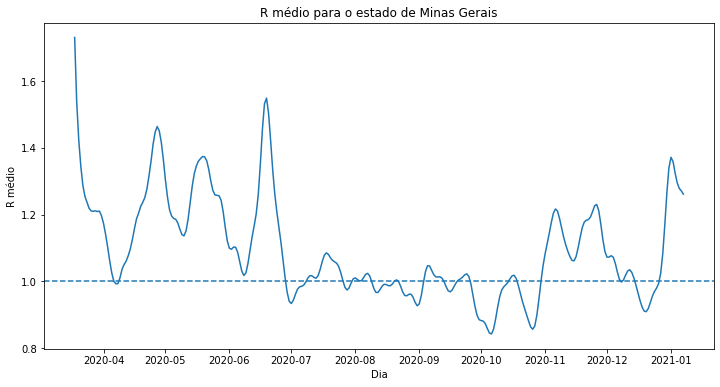

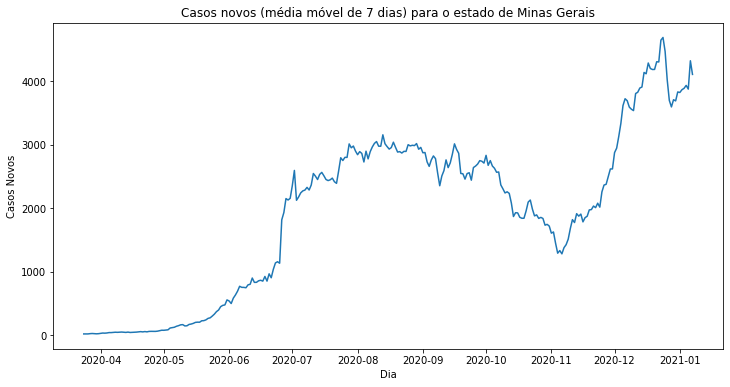

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=dados_covid_sudeste_mg, x='data', y='R_mean')
plt.title('R médio para o estado de Minas Gerais')
plt.xlabel('Dia')
plt.ylabel('R médio')
ax.axhline(1, ls='--')
ax;

print('\n')

df = dados_covid_sudeste_mg.groupby('data').sum()
df['casosNovos_mediamovel'] = df['casosNovos'].rolling(7).mean() #criando as médias móveis

plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df, x='data', y='casosNovos_mediamovel')
plt.title('Casos novos (média móvel de 7 dias) para o estado de Minas Gerais')
plt.xlabel('Dia')
plt.ylabel('Casos Novos')
ax;

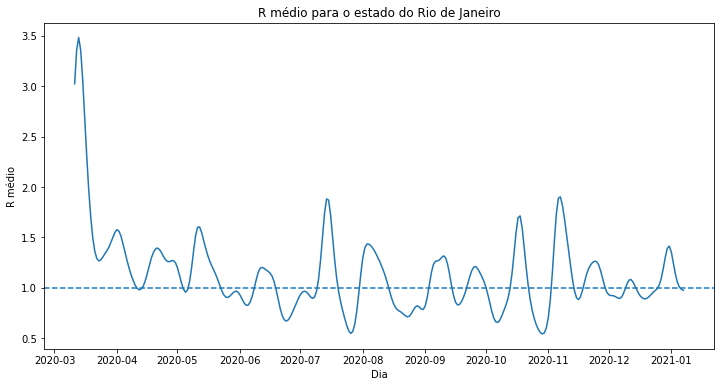

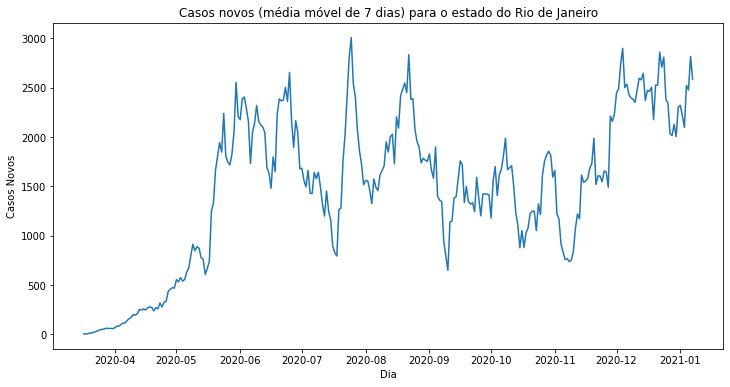

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=dados_covid_sudeste_rj, x='data', y='R_mean')
plt.title('R médio para o estado do Rio de Janeiro')
plt.xlabel('Dia')
plt.ylabel('R médio')
ax.axhline(1, ls='--')
ax;

df = dados_covid_sudeste_rj.groupby('data').sum()
df['casosNovos_mediamovel'] = df['casosNovos'].rolling(7).mean() #criando as médias móveis

plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df, x='data', y='casosNovos_mediamovel')
plt.title('Casos novos (média móvel de 7 dias) para o estado do Rio de Janeiro')
plt.xlabel('Dia')
plt.ylabel('Casos Novos')
ax;

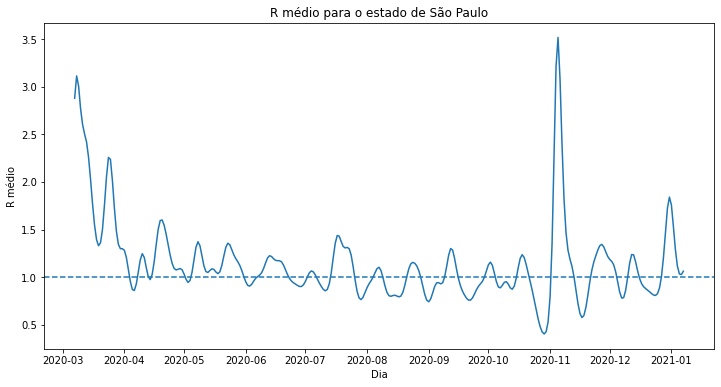

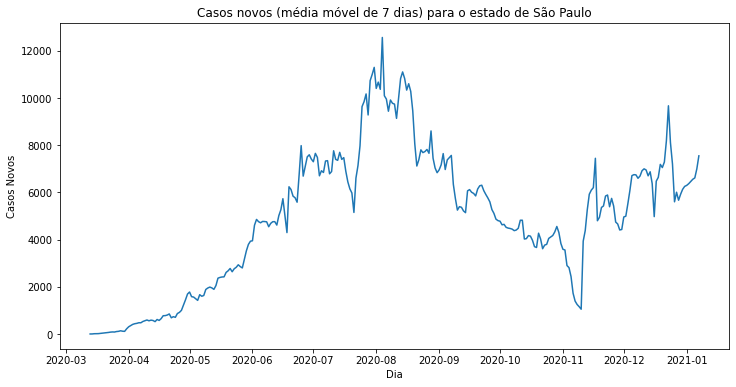

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=dados_covid_sudeste_sp, x='data', y='R_mean')
plt.title('R médio para o estado de São Paulo')
plt.xlabel('Dia')
plt.ylabel('R médio')
ax.axhline(1, ls='--')
ax;

df = dados_covid_sudeste_sp.groupby('data').sum()
df['casosNovos_mediamovel'] = df['casosNovos'].rolling(7).mean() #criando as médias móveis

plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df, x='data', y='casosNovos_mediamovel')
plt.title('Casos novos (média móvel de 7 dias) para o estado de São Paulo')
plt.xlabel('Dia')
plt.ylabel('Casos Novos')
ax;

#Previsão ARIMA

##Minas Gerais

###ARIMA

In [ ]:
decomposicao = seasonal_decompose(dados_covid_sudeste_mg[['data', 'R_mean']].set_index('data'))
decomposicao

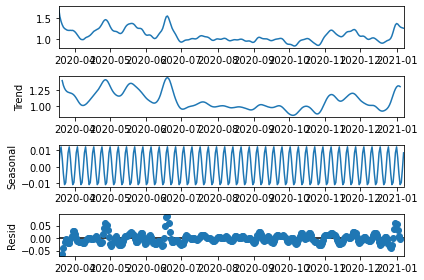

In [ ]:
decomposicao.plot(); #o erro foi menor no modelo aditivo

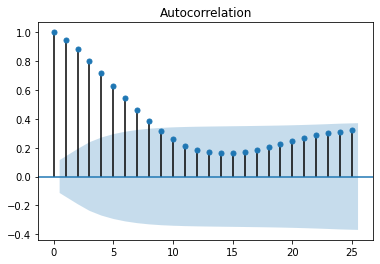

In [ ]:
plot_acf(dados_covid_sudeste_mg['R_mean']); #entendendo autocorrelação

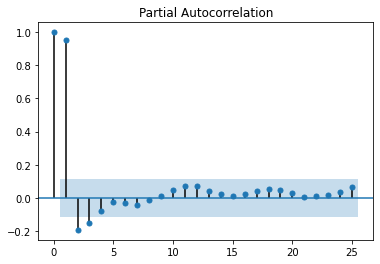

In [ ]:
plot_pacf(dados_covid_sudeste_mg['R_mean']); #entendendo autocorrelação parcial

In [ ]:
dados_treino = dados_covid_sudeste_mg[:-31]
dados_teste = dados_covid_sudeste_mg[-31:]

In [ ]:
modelo_arima = ARIMA(dados_treino['R_mean'].values.astype('float32'), order=[2,0,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(31)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



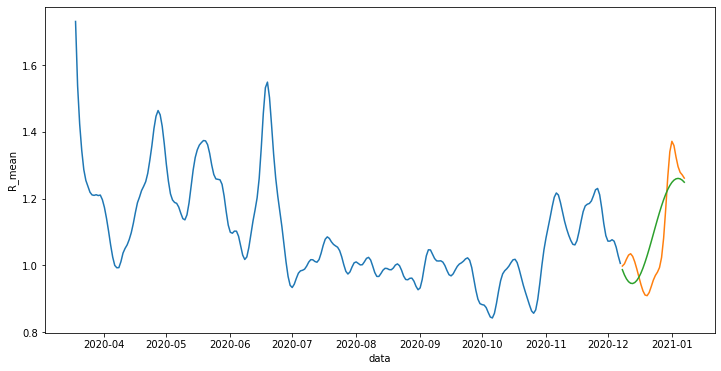

In [ ]:
dados_teste['Previsao'] = previsao

plt.figure(figsize=(12,6))
sns.lineplot(data=dados_treino, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='Previsao')

###AUTOARIMA

In [ ]:
modelo_autoarima = auto_arima(dados_treino['R_mean'].values, error_action='ignore', trace=True, d=0, D=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1846.889, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-244.890, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=807.768, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1634.875, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1719.835, Time=0.51 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1878.872, Time=0.73 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1834.474, Time=0.77 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-1882.829, Time=0.92 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-1812.512, Time=0.93 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-1891.990, Time=1.01 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-1845.054, Time=1.32 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-1699.703, Time=1.48 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



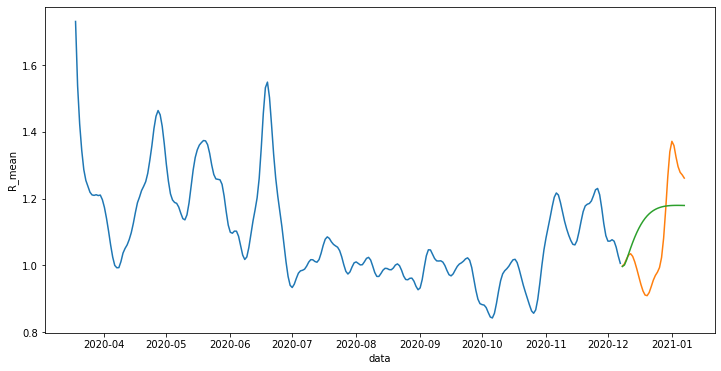

In [ ]:
previsao_autoarima = modelo_autoarima.predict(n_periods=31)
dados_teste['previsao_autoarima'] = previsao_autoarima

plt.figure(figsize=(12,6))
sns.lineplot(data=dados_treino, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='previsao_autoarima')

O modelo ARIMA se comportou melhor.

In [ ]:
modelo_arima = ARIMA(dados_treino['R_mean'].values.astype('float32'), order=[2,0,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(120)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




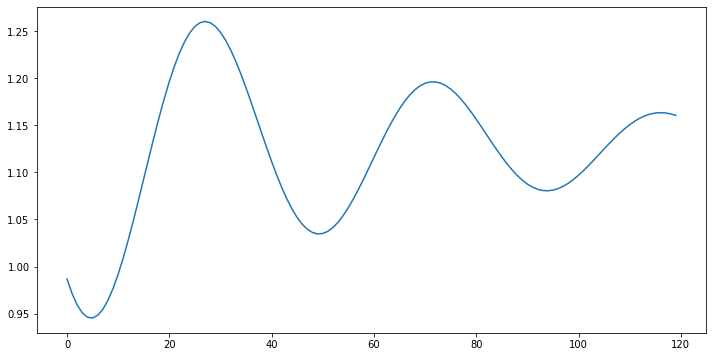

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=previsao)

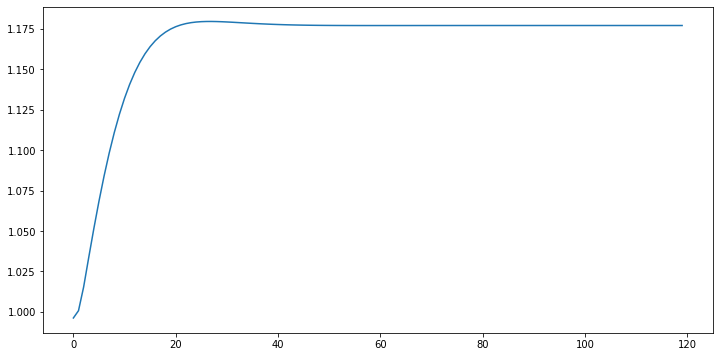

In [ ]:
previsao_autoarima = modelo_autoarima.predict(n_periods=120)

plt.figure(figsize=(12,6))
sns.lineplot(data=previsao_autoarima)

##São Paulo

###ARIMA

In [ ]:
decomposicao = seasonal_decompose(dados_covid_sudeste_sp[['data', 'R_mean']].set_index('data'))
decomposicao

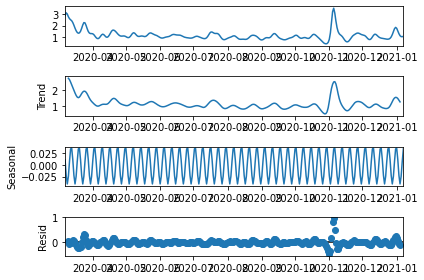

In [ ]:
decomposicao.plot(); #o erro foi menor no modelo aditivo

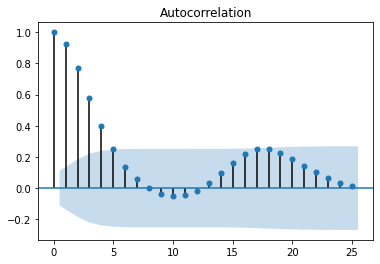

In [ ]:
plot_acf(dados_covid_sudeste_sp['R_mean']); #entendendo autocorrelação

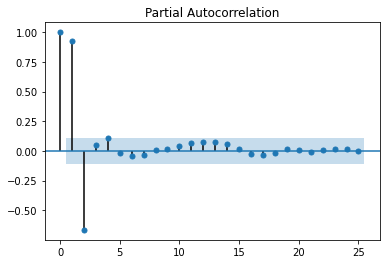

In [ ]:
plot_pacf(dados_covid_sudeste_sp['R_mean']); #entendendo autocorrelação parcial

In [ ]:
dados_treino = dados_covid_sudeste_sp[:-31]
dados_teste = dados_covid_sudeste_sp[-31:]

In [ ]:
modelo_arima = ARIMA(dados_treino['R_mean'].values.astype('float32'), order=[5,0,2])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(31)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



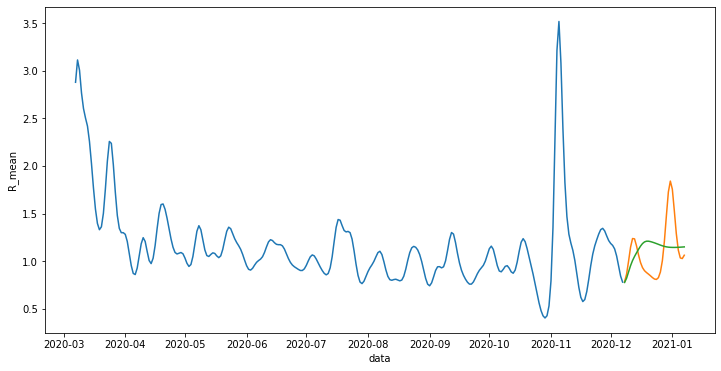

In [ ]:
dados_teste['Previsao'] = previsao

plt.figure(figsize=(12,6))
sns.lineplot(data=dados_treino, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='Previsao')

###AUTOARIMA

In [ ]:
modelo_autoarima = auto_arima(dados_treino['R_mean'].values, error_action='ignore', trace=True, d=0, D=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1132.269, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=350.946, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-303.339, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=904.654, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-937.000, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1189.215, Time=0.76 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1144.398, Time=0.74 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-1192.049, Time=0.85 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-1197.756, Time=0.87 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1076.698, Time=0.68 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-1062.609, Time=1.37 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-907.526, Time=0.50 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



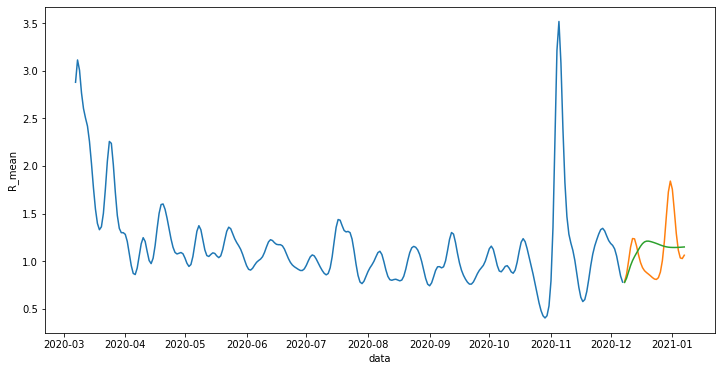

In [ ]:
previsao_autoarima = modelo_autoarima.predict(n_periods=31)
dados_teste['previsao_autoarima'] = previsao_autoarima

plt.figure(figsize=(12,6))
sns.lineplot(data=dados_treino, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='previsao_autoarima')

O modelo ARIMA se comportou melhor.

In [ ]:
modelo_arima = ARIMA(dados_treino['R_mean'].values.astype('float32'), order=[2,0,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(120)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




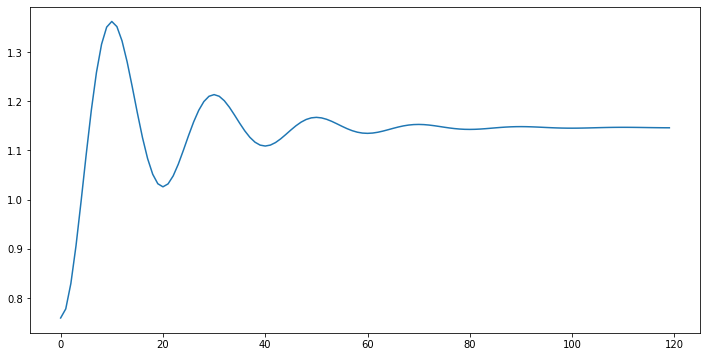

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=previsao)

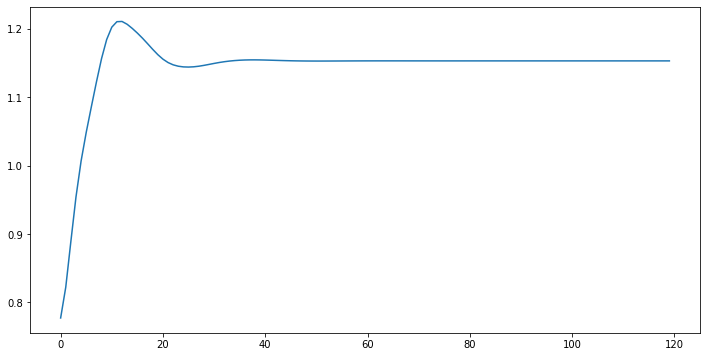

In [ ]:
previsao_autoarima = modelo_autoarima.predict(n_periods=120)

plt.figure(figsize=(12,6))
sns.lineplot(data=previsao_autoarima)

##Rio de Janeiro

###ARIMA

In [ ]:
decomposicao = seasonal_decompose(dados_covid_sudeste_rj[['data', 'R_mean']].set_index('data'))
decomposicao

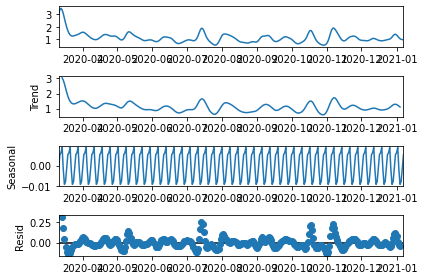

In [ ]:
decomposicao.plot(); #o erro foi menor no modelo aditivo

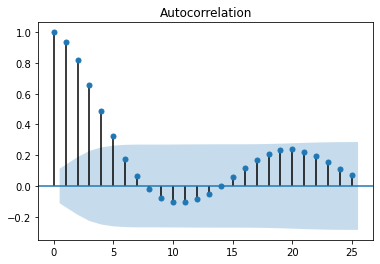

In [ ]:
plot_acf(dados_covid_sudeste_rj['R_mean']); #entendendo autocorrelação

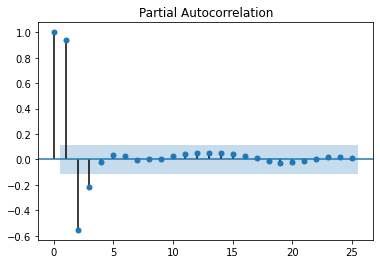

In [ ]:
plot_pacf(dados_covid_sudeste_rj['R_mean']); #entendendo autocorrelação parcial

In [ ]:
dados_treino = dados_covid_sudeste_rj[:-31]
dados_teste = dados_covid_sudeste_rj[-31:]

In [ ]:
modelo_arima = ARIMA(dados_treino['R_mean'].values.astype('float32'), order=[4,0,4])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(31)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



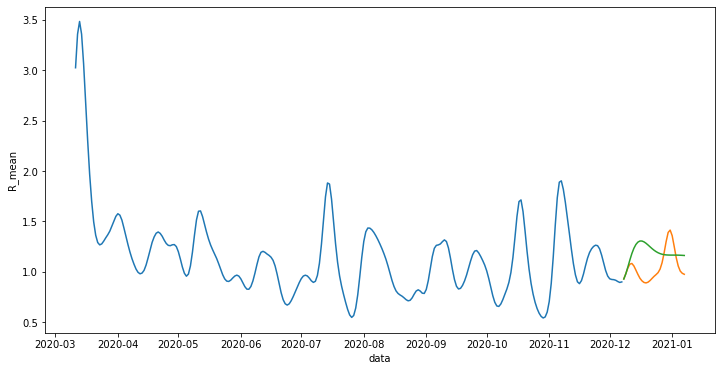

In [ ]:
dados_teste['Previsao'] = previsao

plt.figure(figsize=(12,6))
sns.lineplot(data=dados_treino, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='Previsao')

###AUTOARIMA

In [ ]:
modelo_autoarima = auto_arima(dados_treino['R_mean'].values, error_action='ignore', trace=True, d=0, D=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1558.613, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=313.909, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=883.445, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1128.363, Time=0.53 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1367.592, Time=0.83 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1706.437, Time=0.75 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1570.566, Time=1.15 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-1737.928, Time=0.88 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-1510.756, Time=0.96 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-1689.989, Time=1.05 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-1735.582, Time=0.93 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-1733.328, Time=0.84 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



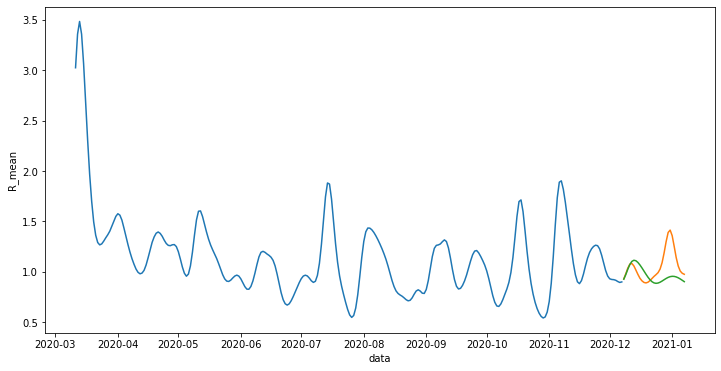

In [ ]:
previsao_autoarima = modelo_autoarima.predict(n_periods=31)
dados_teste['previsao_autoarima'] = previsao_autoarima

plt.figure(figsize=(12,6))
sns.lineplot(data=dados_treino, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='R_mean')
sns.lineplot(data=dados_teste, x='data', y='previsao_autoarima')

O modelo ARIMA se comportou melhor.

In [ ]:
modelo_arima = ARIMA(dados_treino['R_mean'].values.astype('float32'), order=[2,0,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(120)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



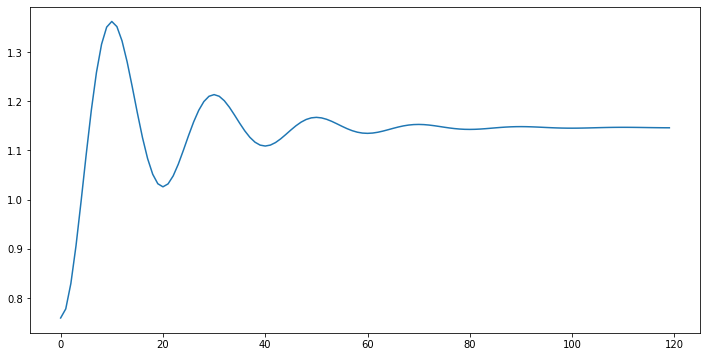

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=previsao)

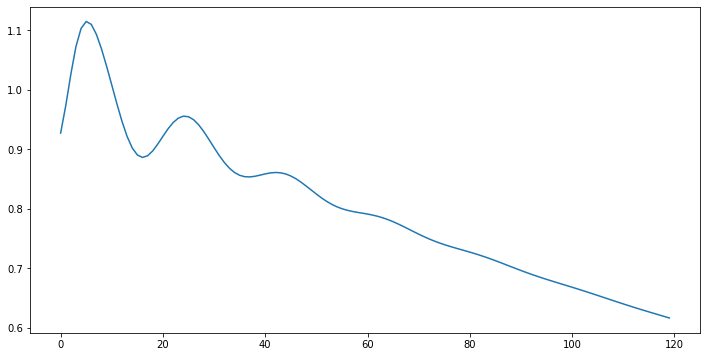

In [ ]:
previsao_autoarima = modelo_autoarima.predict(n_periods=120)

plt.figure(figsize=(12,6))
sns.lineplot(data=previsao_autoarima)

#Previsao Prophet
Prevendo o R estimado para prever futuros picos.

##Minas Gerais

In [ ]:
dados_covid_sudeste_mg_treino = dados_covid_sudeste_mg[:-7]

In [ ]:
modelo_profeta = Prophet(mcmc_samples=600, interval_width=0.5, changepoint_prior_scale=0.15)
mapa = {'data' : 'ds',
        'R_mean' : 'y'}
dados_treino_covid_mg_profeta = dados_covid_sudeste_mg_treino[['data', 'R_mean']].rename(mapa, axis=1)

modelo_profeta_treinado = modelo_profeta.fit(dados_treino_covid_mg_profeta)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
futuro = modelo_profeta_treinado.make_future_dataframe(periods=90, freq='D')
futuro

,ds
0,2020-03-18
1,2020-03-19
2,2020-03-20
3,2020-03-21
4,2020-03-22
...,...
374,2021-03-27
375,2021-03-28
376,2021-03-29
377,2021-03-30


In [ ]:
resultado_profeta = modelo_profeta_treinado.predict(futuro)
resultado_profeta

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-18,1.305449,1.232362,1.394704,1.277142,1.332877,0.007421,-0.003446,0.017785,0.007421,-0.003446,0.017785,0.0,0.0,0.0,1.312871
1,2020-03-19,1.297919,1.238405,1.390897,1.271722,1.323243,0.013806,0.003601,0.023754,0.013806,0.003601,0.023754,0.0,0.0,0.0,1.311725
2,2020-03-20,1.290390,1.226350,1.374099,1.265399,1.314357,0.008411,-0.001138,0.017346,0.008411,-0.001138,0.017346,0.0,0.0,0.0,1.298800
3,2020-03-21,1.282860,1.209853,1.362104,1.260152,1.305488,0.002622,-0.007148,0.012811,0.002622,-0.007148,0.012811,0.0,0.0,0.0,1.285481
4,2020-03-22,1.275330,1.193309,1.342731,1.254604,1.295955,-0.007138,-0.017203,0.003187,-0.007138,-0.017203,0.003187,0.0,0.0,0.0,1.268192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,2021-03-27,1.090536,0.908536,1.280433,0.919283,1.262192,0.002622,-0.007148,0.012811,0.002622,-0.007148,0.012811,0.0,0.0,0.0,1.093158
375,2021-03-28,1.090793,0.874165,1.274869,0.914348,1.267375,-0.007138,-0.017203,0.003187,-0.007138,-0.017203,0.003187,0.0,0.0,0.0,1.083656
376,2021-03-29,1.091051,0.876644,1.265924,0.911994,1.270656,-0.013724,-0.024191,-0.003847,-0.013724,-0.024191,-0.003847,0.0,0.0,0.0,1.077327
377,2021-03-30,1.091308,0.860748,1.271437,0.906455,1.274223,-0.011399,-0.020765,-0.001188,-0.011399,-0.020765,-0.001188,0.0,0.0,0.0,1.079909


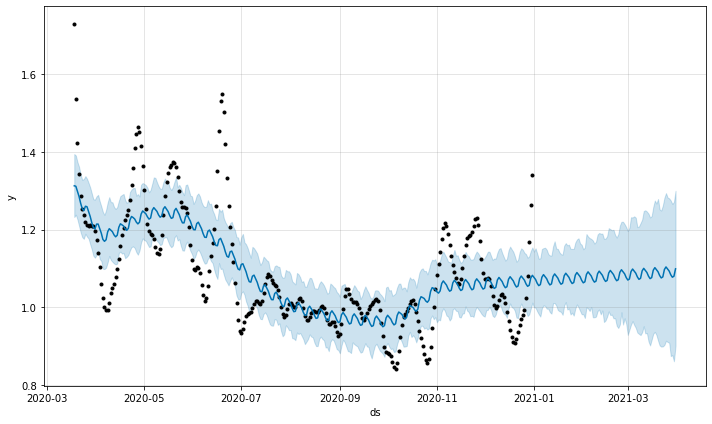

In [ ]:
modelo_profeta_treinado.plot(resultado_profeta);

##São Paulo

In [ ]:
dados_covid_sudeste_sp_treino = dados_covid_sudeste_sp[:-7]

In [ ]:
modelo_profeta = Prophet(mcmc_samples=600, interval_width=0.5, changepoint_prior_scale=0.15)
mapa = {'data' : 'ds',
        'R_mean' : 'y'}
dados_treino_covid_sp_profeta = dados_covid_sudeste_sp_treino[['data', 'R_mean']].rename(mapa, axis=1)

modelo_profeta_treinado = modelo_profeta.fit(dados_treino_covid_sp_profeta)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
futuro = modelo_profeta_treinado.make_future_dataframe(periods=90, freq='D')
futuro

,ds
0,2020-03-07
1,2020-03-08
2,2020-03-09
3,2020-03-10
4,2020-03-11
...,...
385,2021-03-27
386,2021-03-28
387,2021-03-29
388,2021-03-30


In [ ]:
resultado_profeta = modelo_profeta_treinado.predict(futuro)
resultado_profeta

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-07,2.319128,2.060502,2.563439,2.251690,2.387824,0.009150,-0.020494,0.041816,0.009150,-0.020494,0.041816,0.0,0.0,0.0,2.328278
1,2020-03-08,2.284765,2.017557,2.505006,2.220345,2.351003,-0.013269,-0.044917,0.018432,-0.013269,-0.044917,0.018432,0.0,0.0,0.0,2.271496
2,2020-03-09,2.250402,1.962865,2.466024,2.187956,2.314957,-0.030808,-0.061951,0.001713,-0.030808,-0.061951,0.001713,0.0,0.0,0.0,2.219594
3,2020-03-10,2.216039,1.988627,2.451819,2.155418,2.276864,-0.022145,-0.056557,0.010919,-0.022145,-0.056557,0.010919,0.0,0.0,0.0,2.193894
4,2020-03-11,2.181676,1.939407,2.429552,2.123774,2.237480,0.007342,-0.024586,0.041546,0.007342,-0.024586,0.041546,0.0,0.0,0.0,2.189018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2021-03-27,1.129109,0.749429,1.520514,0.819782,1.452044,0.009150,-0.020494,0.041816,0.009150,-0.020494,0.041816,0.0,0.0,0.0,1.138259
386,2021-03-28,1.129251,0.696668,1.529959,0.811571,1.457738,-0.013269,-0.044917,0.018432,-0.013269,-0.044917,0.018432,0.0,0.0,0.0,1.115981
387,2021-03-29,1.129392,0.687688,1.524251,0.811725,1.460141,-0.030808,-0.061951,0.001713,-0.030808,-0.061951,0.001713,0.0,0.0,0.0,1.098584
388,2021-03-30,1.129533,0.688843,1.517621,0.812281,1.465297,-0.022145,-0.056557,0.010919,-0.022145,-0.056557,0.010919,0.0,0.0,0.0,1.107388


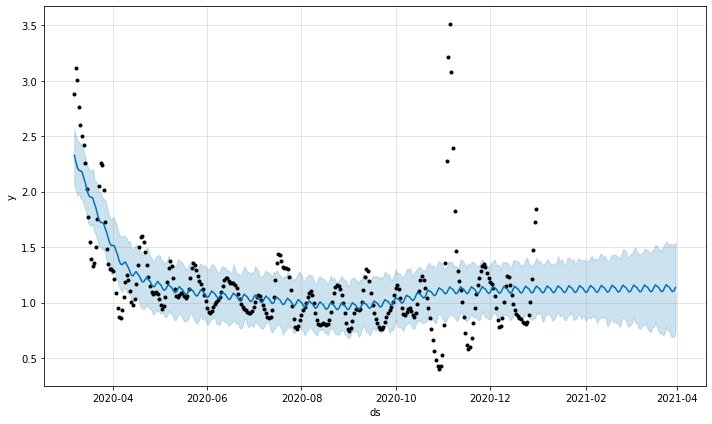

In [ ]:
modelo_profeta_treinado.plot(resultado_profeta);

##Rio de Janeiro

In [ ]:
dados_covid_sudeste_rj_treino = dados_covid_sudeste_rj[:-7]

In [ ]:
modelo_profeta = Prophet(mcmc_samples=600, interval_width=0.5, changepoint_prior_scale=0.15)
mapa = {'data' : 'ds',
        'R_mean' : 'y'}
dados_treino_covid_rj_profeta = dados_covid_sudeste_rj_treino[['data', 'R_mean']].rename(mapa, axis=1)

modelo_profeta_treinado = modelo_profeta.fit(dados_treino_covid_rj_profeta)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
futuro = modelo_profeta_treinado.make_future_dataframe(periods=90, freq='D')
futuro

,ds
0,2020-03-11
1,2020-03-12
2,2020-03-13
3,2020-03-14
4,2020-03-15
...,...
381,2021-03-27
382,2021-03-28
383,2021-03-29
384,2021-03-30


In [ ]:
resultado_profeta = modelo_profeta_treinado.predict(futuro)
resultado_profeta

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-11,2.429500,2.194930,2.644669,2.349672,2.508741,0.002013,-0.028429,0.032649,0.002013,-0.028429,0.032649,0.0,0.0,0.0,2.431513
1,2020-03-12,2.382698,2.177673,2.619175,2.308377,2.456572,0.013734,-0.015770,0.043323,0.013734,-0.015770,0.043323,0.0,0.0,0.0,2.396432
2,2020-03-13,2.335895,2.117696,2.552708,2.267026,2.404987,0.011494,-0.018067,0.040118,0.011494,-0.018067,0.040118,0.0,0.0,0.0,2.347389
3,2020-03-14,2.289093,2.062896,2.507948,2.224071,2.352806,0.006066,-0.022695,0.034920,0.006066,-0.022695,0.034920,0.0,0.0,0.0,2.295158
4,2020-03-15,2.242290,2.015184,2.443393,2.181679,2.301272,-0.005447,-0.032755,0.022717,-0.005447,-0.032755,0.022717,0.0,0.0,0.0,2.236843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2021-03-27,1.064673,0.645584,1.503249,0.711250,1.389604,0.006066,-0.022695,0.034920,0.006066,-0.022695,0.034920,0.0,0.0,0.0,1.070739
382,2021-03-28,1.064620,0.622601,1.456488,0.706559,1.393894,-0.005447,-0.032755,0.022717,-0.005447,-0.032755,0.022717,0.0,0.0,0.0,1.059173
383,2021-03-29,1.064566,0.607918,1.472137,0.698152,1.400885,-0.012043,-0.042003,0.018454,-0.012043,-0.042003,0.018454,0.0,0.0,0.0,1.052523
384,2021-03-30,1.064513,0.630743,1.457480,0.692571,1.406264,-0.015818,-0.047293,0.016361,-0.015818,-0.047293,0.016361,0.0,0.0,0.0,1.048695


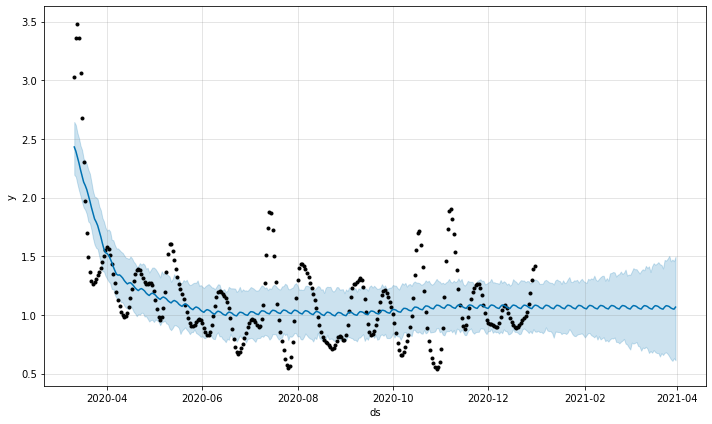

In [ ]:
modelo_profeta_treinado.plot(resultado_profeta);